In [32]:
import io
from functools import lru_cache

import altair as alt
import pandas as pd
import requests

import matplotlib.pyplot as plt

In [33]:
data_url = "https://raw.githubusercontent.com/thohan88/covid19-nor-data/HEAD/data"


@lru_cache()
def download_dataset(path):
    """Download a dataset from covid19-nor-data archive"""
    url = f"{data_url}/{path}"
    print(f"Downloading {url}")
    r = requests.get(f"{data_url}/{path}")
    r.raise_for_status()
    print(f"Downloaded {len(r.content) // 1024}kB")
    return pd.read_csv(io.BytesIO(r.content), parse_dates=["date"])


all_cases = download_dataset("01_infected/msis/municipality_and_district.csv")
all_cases

Downloaded 18604kB


,date,date_time,kommune_bydel_no,kommune_bydel_name,bydel_no,bydel_name,kommune_no,kommune_name,fylke_no,fylke_name,population,cases
0,2020-03-26,2020-03-26T04:00:00Z,30101,Gamle Oslo,30101.0,Gamle Oslo,301,Oslo,3,Oslo,58671,67
1,2020-03-26,2020-03-26T04:00:00Z,30102,Grünerløkka,30102.0,Grünerløkka,301,Oslo,3,Oslo,62423,59
2,2020-03-26,2020-03-26T04:00:00Z,30103,Sagene,30103.0,Sagene,301,Oslo,3,Oslo,45089,47
3,2020-03-26,2020-03-26T04:00:00Z,30104,St. Hanshaugen,30104.0,St. Hanshaugen,301,Oslo,3,Oslo,38945,33
4,2020-03-26,2020-03-26T04:00:00Z,30105,Frogner,30105.0,Frogner,301,Oslo,3,Oslo,59269,67
...,...,...,...,...,...,...,...,...,...,...,...,...
227497,2021-11-10,2021-11-10T04:00:00Z,5442,Nesseby,NaN,NaN,5442,Nesseby,54,Troms og Finnmark,926,8
227498,2021-11-10,2021-11-10T04:00:00Z,5443,Båtsfjord,NaN,NaN,5443,Båtsfjord,54,Troms og Finnmark,2221,25
227499,2021-11-10,2021-11-10T04:00:00Z,5444,Sør-Varanger,NaN,NaN,5444,Sør-Varanger,54,Troms og Finnmark,10158,95
227500,2021-11-10,2021-11-10T04:00:00Z,9998,Svalbard,NaN,NaN,9998,Svalbard,99,Svalbard,0,0


In [34]:
# aggregate data by fylke
cases = (
    all_cases.groupby(["fylke_name", "date"])[["cases", "population"]]
    .sum()
    .reset_index()
)
cases

,fylke_name,date,cases,population
0,Agder,2020-03-26,133,307231
1,Agder,2020-03-27,148,307231
2,Agder,2020-03-28,159,307231
3,Agder,2020-03-29,161,307231
4,Agder,2020-03-30,166,307231
...,...,...,...,...
7717,Viken,2021-11-06,67294,1241165
7718,Viken,2021-11-07,67556,1241165
7719,Viken,2021-11-08,67780,1241165
7720,Viken,2021-11-09,68166,1241165


In [35]:
# discard ukjent fylke where population 100k doesn't make sense
cases = cases[~cases.fylke_name.str.contains("Ukjent")]
cases

,fylke_name,date,cases,population
0,Agder,2020-03-26,133,307231
1,Agder,2020-03-27,148,307231
2,Agder,2020-03-28,159,307231
3,Agder,2020-03-29,161,307231
4,Agder,2020-03-30,166,307231
...,...,...,...,...
7717,Viken,2021-11-06,67294,1241165
7718,Viken,2021-11-07,67556,1241165
7719,Viken,2021-11-08,67780,1241165
7720,Viken,2021-11-09,68166,1241165


In [36]:
# 'cases' is a cumulative sum
# reverse that to calculate the daily new case count

# 1. createe a new column
cases["daily cases"] = 0

# 2. populate it per fylke
for fylke in cases.fylke_name.unique():
    mask = cases.fylke_name == fylke
    fylke_cases = cases.loc[mask]
    diff = fylke_cases.cases.diff()
    # set first value from cases
    diff.iloc[0] = fylke_cases.iloc[0].cases
    cases.loc[fylke_cases.index, "daily cases"] = diff.astype(int)

cases

/Users/minrk/conda/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/minrk/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,fylke_name,date,cases,population,daily cases
0,Agder,2020-03-26,133,307231,133
1,Agder,2020-03-27,148,307231,15
2,Agder,2020-03-28,159,307231,11
3,Agder,2020-03-29,161,307231,2
4,Agder,2020-03-30,166,307231,5
...,...,...,...,...,...
7717,Viken,2021-11-06,67294,1241165,277
7718,Viken,2021-11-07,67556,1241165,262
7719,Viken,2021-11-08,67780,1241165,224
7720,Viken,2021-11-09,68166,1241165,386


# Add per-100,000 population column

In [37]:
# per100k is "daily new cases per 100k population"
cases["per100k"] = (
    (cases["daily cases"] * 1e5 / (cases["population"] + 1))
)
cases

/Users/minrk/conda/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,fylke_name,date,cases,population,daily cases,per100k
0,Agder,2020-03-26,133,307231,133,43.289761
1,Agder,2020-03-27,148,307231,15,4.882304
2,Agder,2020-03-28,159,307231,11,3.580356
3,Agder,2020-03-29,161,307231,2,0.650974
4,Agder,2020-03-30,166,307231,5,1.627435
...,...,...,...,...,...,...
7717,Viken,2021-11-06,67294,1241165,277,22.317724
7718,Viken,2021-11-07,67556,1241165,262,21.109183
7719,Viken,2021-11-08,67780,1241165,224,18.047546
7720,Viken,2021-11-09,68166,1241165,386,31.099788


## Exercise

plot cases per 1000 by fylke over time

In [38]:
latest_cases = cases[-5000:]

In [39]:
latest_cases.columns

Index(['fylke_name', 'date', 'cases', 'population', 'daily cases', 'per100k'], dtype='object')

In [49]:
subset = cases[cases.fylke_name.isin(["Oslo", "Viken"])]


daily = alt.Chart(subset).mark_point().encode(
    x="date:T",
    y="per100k",
    color="fylke_name",
    tooltip=[
        "fylke_name",
        "population",
        "per100k",
        "cases",
    ]
)
daily

alt.Chart(...)

In [60]:
weekly = alt.Chart(subset).mark_line().transform_window(
    weekly_avg="mean(per100k)",
    frame=[-3, 3],
).encode(
    x="date:T",
    y="weekly_avg:Q",
    color="fylke_name",
    tooltip=[
        "fylke_name",
        "population",
        "per100k",
        "cases",
    ]

)
weekly

alt.Chart(...)

In [61]:
weekly + daily

alt.LayerChart(...)

We can also do the same with matplotlib

/var/folders/qr/3vxfnp1x2t1fw55dr288mphc0000gn/T/ipykernel_80365/1582759968.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subset.groupby("fylke_name")["date", "per100k"].plot(x="date", y="per100k", legend=True)


fylke_name
Oslo     AxesSubplot(0.125,0.2;0.775x0.68)
Viken    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

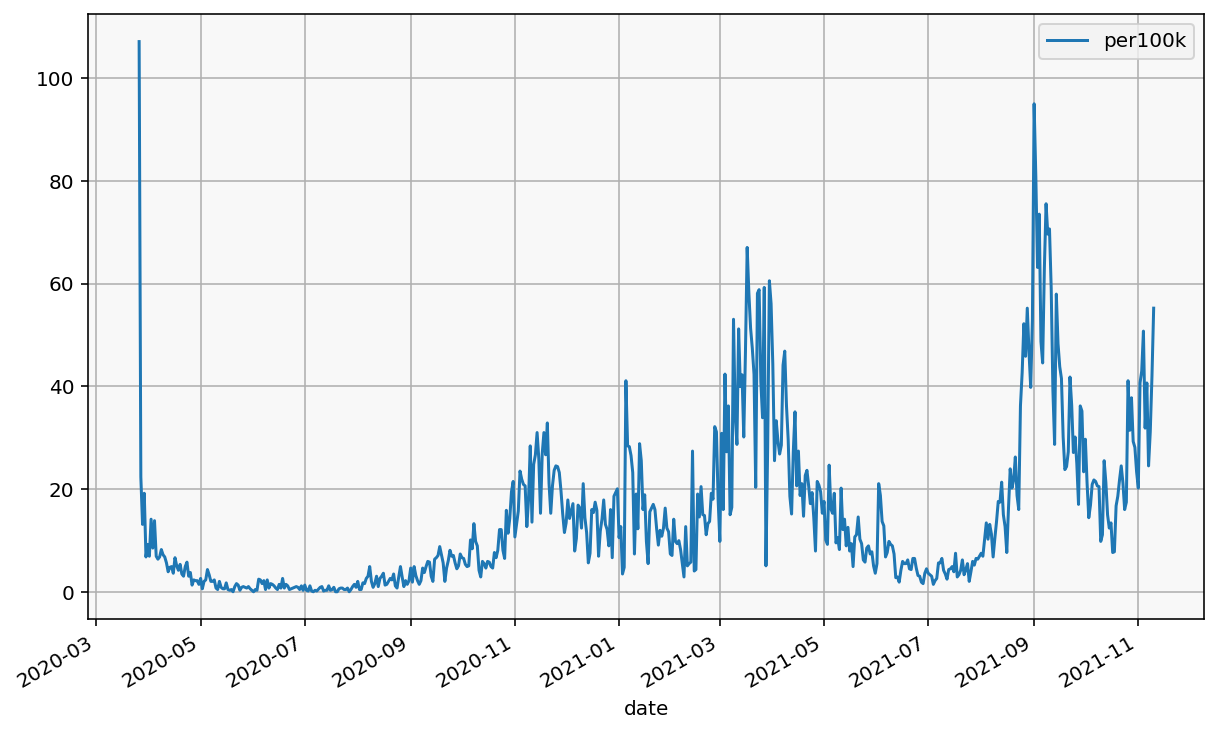

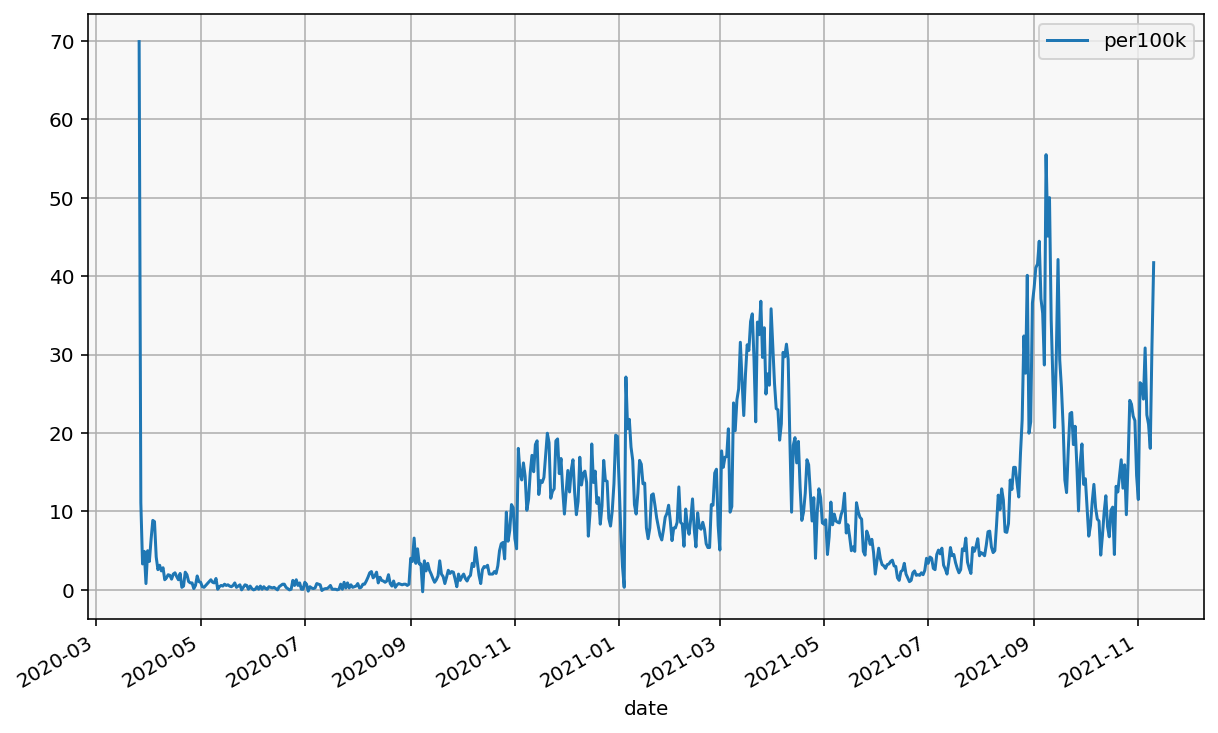

In [67]:
subset.groupby("fylke_name")["date", "per100k"].plot(x="date", y="per100k", legend=True)

fylke_name
Oslo     AxesSubplot(0.125,0.2;0.775x0.68)
Viken    AxesSubplot(0.125,0.2;0.775x0.68)
Name: per100k, dtype: object

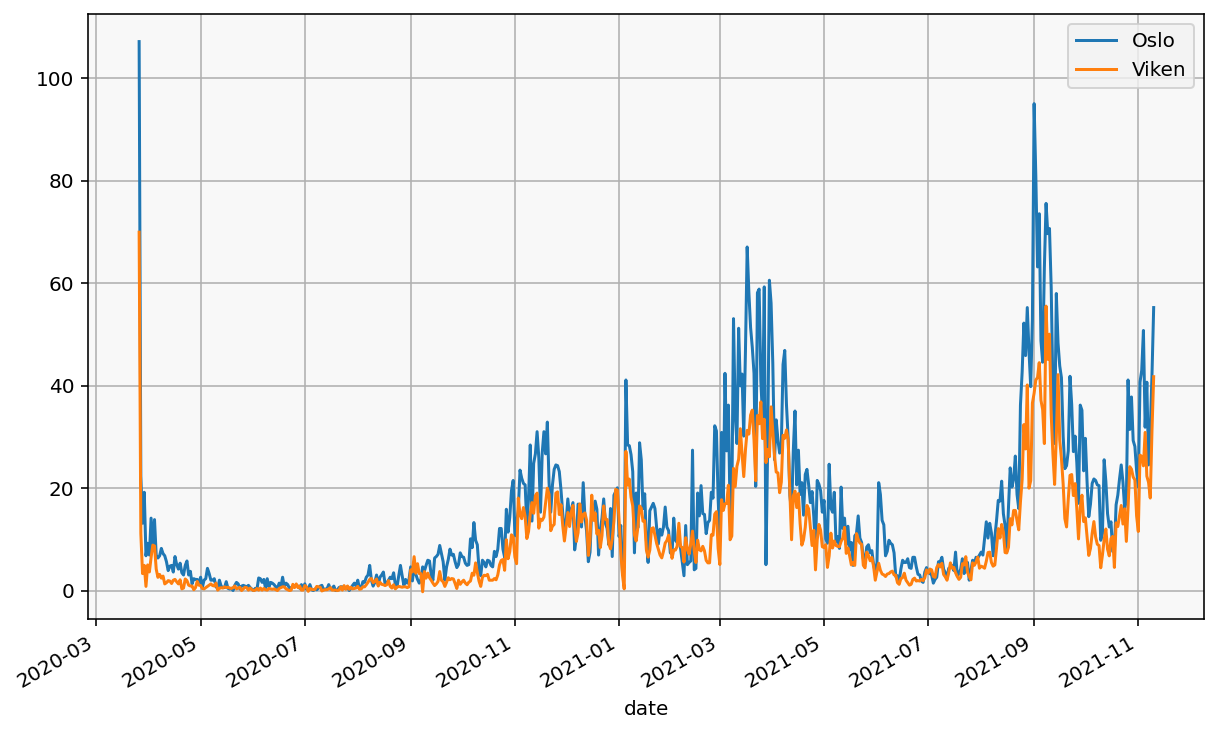

In [66]:
subset.set_index("date").groupby("fylke_name").per100k.plot(legend=True)